In [2]:
# vid files of the form:
# magnitude_speed_body_L#.mov
# magnitude: great/small - relative magnitude of joint displacement
# speed:     slow/fast - relative speed of movements
# body:      legs/arms/both - where is the movement focused
# L/E #:     Lauren or Emma, choreography numbering

# Each set of choreography is done by two individuals 
# to see if the algorithm matches similar choreography across different dancers
# by labeling the 2-d PCA plot by choreography number. The L/E labels is to ensure
# videos of the same choreography have different file names.

# We can also label the PCA by the four different permutations of 
# choreography tags, to see if similar categories are grouped together.

In [3]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
# Collecting dance files and setting test constants
data_path = "/Users/emmawaters/Desktop/Dance/blackTest/"
vid_names = []
dir_list = os.listdir(data_path)
for i in dir_list:
    if i.endswith(".mp4"):
        vid_names.append(i)

NUM_FRAMES = float('inf')
NUM_PARTS = 15
NUM_TIME_CHUNKS = 5
NUM_VIDS = len(vid_names)
print(vid_names)
print(NUM_VIDS)

['great_fast_arms_L1.mp4', 'great_slow_both_L5.mp4', 'great_fast_both_L2.mp4', 'great_slow_arms_L4.mp4', 'small_slow_both_E11.mp4', 'small_fast_both_L8.mp4', 'small_fast_legs_E9.mp4', 'great_fast_legs_E3.mp4', 'great_slow_legs_E6.mp4', 'small_fast_arms_E7.mp4', 'small_slow_arms_L10.mp4', 'small_slow_legs_E12.mp4', 'great_fast_both_E2.mp4', 'great_slow_both_E5.mp4', 'great_slow_arms_E4.mp4', 'small_fast_both_E8.mp4', 'great_fast_arms_E1.mp4', 'small_slow_both_L11.mp4', 'small_fast_arms_L7.mp4', 'great_slow_legs_L6.mp4', 'small_fast_legs_L9.mp4', 'small_slow_arms_E10.mp4', 'great_fast_legs_L3.mp4', 'small_slow_legs_L12.mp4']
24


In [5]:
# read_video_to_movement returns the list of joint positions found using openCV
# Also returns a count of the number of joints not found, to be used to measure accuracy

def read_video_to_movement(vidpath):
    data = []
    net = cv.dnn.readNetFromTensorflow("graph_opt.pb")
    cap = cv.VideoCapture(vidpath)

    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Background": 14 }

    POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"] ]

    error = 0
    while cv.waitKey(1) < 0:
        hasFrame, frame = cap.read()
        if not hasFrame:
            break

        #frame = cv.rotate(frame, cv.ROTATE_180) #ONLY needed if raw iPhone data
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        net.setInput(cv.dnn.blobFromImage(frame, 1.0, (368, 368), (127.5, 127.5, 127.5), swapRB=True, crop=False))
        out = net.forward()
        out = out[:, :15, :, :]

        assert(len(BODY_PARTS) == out.shape[1])

        points = []
        for i in range(len(BODY_PARTS)):
            heatMap = out[0, i, :, :]
            _, conf, _, point = cv.minMaxLoc(heatMap)
            x = (frameWidth * point[0]) / out.shape[3]
            y = (frameHeight * point[1]) / out.shape[2]
            if conf > 0.1:
                points.append(np.array([x, y]))
            else:
                points.append(np.array([None,None]))
                error += 1

        data.append(points)
    return (data, error)

In [6]:
# Collect movements in a list, calculate number of missed joints
movement_list = []
total_missed = 0
total_frames = 0

for i in range(len(vid_names)):
    print(i) # Cheap Status Bar
    (movement, missed) = read_video_to_movement(data_path + vid_names[i])
    movement_list.append(movement)
    vid_frames = len(movement)
    total_missed += missed
    total_frames += vid_frames
    if vid_frames < NUM_FRAMES:
        NUM_FRAMES = vid_frames
        
# Compare number of missed joints to the number of expected joints
expected_num_joints = vid_frames * 15 * NUM_VIDS
error_factor = total_missed/expected_num_joints
print(error_factor)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0.08871283255086072


In [7]:
# vectorize_movement transforms a movement into a characteristic vector
# A higher value for num_chunks increases the resolution of the characteristics

def vectorize_movement(movement, num_chunks, NUM_PARTS, NUM_FRAMES):
    move_vec = []
    chunk_size = int(NUM_FRAMES/num_chunks)
    for n in range(num_chunks):
        for joint in range(NUM_PARTS):
            x_pos_disp = 0
            x_neg_disp = 0
            y_pos_disp = 0
            y_neg_disp = 0

            for i in range(chunk_size - 1):
                prev_frame = movement[n*chunk_size + i]
                frame = movement[n*chunk_size + i + 1]

                if prev_frame[joint].all() and frame[joint].all():
                    disp = prev_frame[joint] - frame[joint]

                    if disp[0] > 0:
                        x_pos_disp += disp[0]
                    else:
                        x_neg_disp += disp[0]
                    if disp[1] > 0:
                        y_pos_disp += disp[1]
                    else:
                        y_neg_disp += disp[1]
            move_vec += [x_pos_disp, x_neg_disp, y_pos_disp, y_neg_disp]

    return move_vec

In [8]:
# Calculate characteristic vector of each movement
move_vec_list = []
for i in range(NUM_VIDS):     #need to do AFTER determining min num_frames
    move_vec = vectorize_movement(movement_list[i][:NUM_FRAMES], 1, NUM_PARTS, NUM_FRAMES)
    move_vec_list.append(np.array(move_vec))

# X is the data set we will use for PCA
X = np.array(move_vec_list)
print(X.shape)

(24, 60)


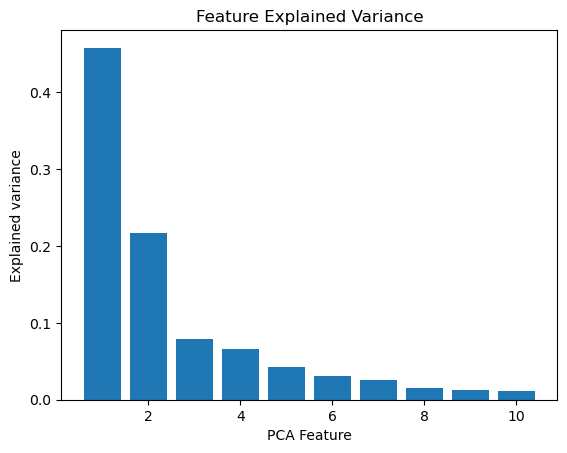

In [9]:
# Scale the data, because that's standard
X_scaled = StandardScaler().fit_transform(X)

# Scree plot with 10 components for data insight
pca_10comp = PCA(n_components=10)
pca_10fit = pca_10comp.fit(X_scaled)

plt.bar(
    range(1,len(pca_10comp.explained_variance_ratio_)+1),
    pca_10comp.explained_variance_ratio_
    )
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [10]:
# PCA with 2 components for 2-d plot
pca_2comp = PCA(n_components=2)
pca_2fit = pca_2comp.fit_transform(X_scaled)

In [24]:
# Create dataframe
pca_df = pd.DataFrame(
    data=pca_2fit, 
    columns=['PC1', 'PC2'])
 
# Generate labels for rows (representing a particular video) by their choreography number and by type
choreo_num_list = []
dance_type_list = []
for i in range(NUM_VIDS):
    file_name = vid_names[i].split('.')[0]
    
    choreo_number = file_name[16:17]
    choreo_num_list.append(choreo_number)
    
    dance_type = file_name[11:15]
    dance_type_list.append(dance_type)

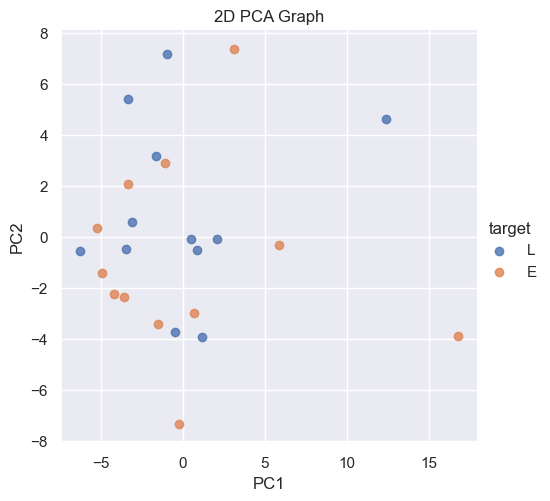

In [25]:
# Scatter plot colored by choreo number
pca_df['target'] = choreo_num_list
sns.set()
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    hue='target', 
    fit_reg=False, 
    legend=True
    )
 
plt.title('2D PCA Graph')
plt.show()

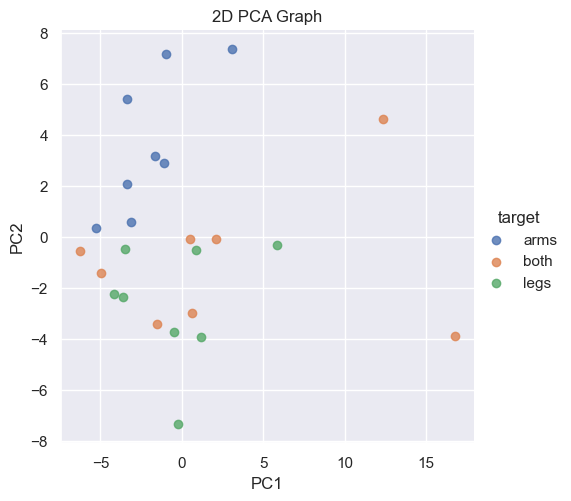

In [26]:
# Scatter plot colored by dance type
pca_df['target'] = dance_type_list
sns.set()
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    hue='target', 
    fit_reg=False, 
    legend=True
    )
 
plt.title('2D PCA Graph')
plt.show()